<a href="https://colab.research.google.com/github/chenxicclu/MIDS_NLP_Project/blob/main/ComVE_Subtask_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

## Confirm that the GPU is detected

In [1]:
!nvidia-smi

Thu Apr  8 05:05:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


Identify and specify the GPU as the device

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Installing libraries

In [4]:
!pip install transformers

     |████████████████████████████████| 2.2MB 16.1MB/s 
     |████████████████████████████████| 3.3MB 56.4MB/s 
     |████████████████████████████████| 870kB 53.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=5ef5b2f1910dd1de46eee406dc48d1aee4c39cb4772588cb0a68f8bb45c0ecef
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [5]:
!pip install pytorch-lightning

     |████████████████████████████████| 839kB 13.5MB/s 
     |████████████████████████████████| 276kB 30.4MB/s 
     |████████████████████████████████| 829kB 52.7MB/s 
     |████████████████████████████████| 184kB 51.6MB/s 
     |████████████████████████████████| 112kB 57.2MB/s 
     |████████████████████████████████| 1.3MB 40.2MB/s 
     |████████████████████████████████| 296kB 40.5MB/s 
     |████████████████████████████████| 143kB 57.1MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=6d82a5166165427e20f1821753929f8f4ade95c3b95eb2d4686d86eac0ebcc63
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=5bcdc7573c9eeed31c413b385c18f84da95edd01977bd25d12edc571e8da5b7b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAM

In [6]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 14.1MB/s 


In [7]:
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
from transformers import DebertaV2Tokenizer, DebertaV2Model, DebertaV2ForMaskedLM, DebertaV2PreTrainedModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional.classification import auroc
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

2.4.1


In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8,6
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Loading ComVe Dataset

### Training Dataset

In [ ]:
# read in training data
train_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Training%20%20Data/subtaskA_data_all.csv")
train_data.shape

(10000, 3)

In [ ]:
train_data.head(20)

id  ...                                              sent1
0    0  ...                      He poured milk on his cereal.
1    1  ...                                    He drinks milk.
2    2  ...                       Jeff ran 100,000 miles today
3    3  ...                                 I sting a mosquito
4    4  ...                             A giraffe is a person.
5    5  ...   A normal closet is larger than a walk-in closet.
6    6  ...                             I like to ride my bike
7    7  ...                     A GIRL WON THE RACE WITH HORSE
8    8  ...                        he pour water in to the jug
9    9  ...                             A dog plays volleyball
10  10  ...                          Kids find eggs on Easter.
11  11  ...                                  Mark drank water.
12  12  ...              He went to the bank to withdraw cash.
13  13  ...                        An employee can price goods
14  14  ...                           she wear hat in the hand
15  15  ...          My cousin throws the house to my brother.
16  16  ...                       Roses buds  eat caterpillars
17  17  ...  Lisa played jazz music for the President of th...
18  18  ...  the computer broke down and the technician wil...
19  19  ...                                     I drank water.

[20 rows x 3 columns]

In [ ]:
# read in training label, no header
train_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Training%20%20Data/subtaskA_answers_all.csv",header=None)
train_label.shape

(10000, 2)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  int64 
 1   sent0   10000 non-null  object
 2   sent1   10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [ ]:
# two columns: id, sentence index that doesn't make sense
train_label.head(10)

0  1
0  0  0
1  1  0
2  2  1
3  3  1
4  4  1
5  5  1
6  6  0
7  7  1
8  8  0
9  9  1

In [ ]:
# check label distribution
print(train_label[1].value_counts())
print(train_label[1].value_counts(normalize = True))

1    5021
0    4979
Name: 1, dtype: int64
1    0.5021
0    0.4979
Name: 1, dtype: float64


### Dev Dataset

In [ ]:
dev_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Dev%20Data/subtaskA_dev_data.csv")
dev_data.shape
dev_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Dev%20Data/subtaskA_gold_answers.csv",header=None)
dev_label.shape

(997, 2)

In [ ]:
dev_label.head(10)

0  1
0  1363  0
1   392  0
2   540  0
3     3  0
4   560  1
5  1703  1
6  1951  1
7   434  1
8  1098  1
9  1758  0

In [ ]:
# count how many sen1 make no sense
dev_label[1].value_counts(normalize = True)

0    0.519559
1    0.480441
Name: 1, dtype: float64

In [ ]:
dev_label[1].value_counts()

0    518
1    479
Name: 1, dtype: int64

### Test Dataset

In [ ]:
test_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Test%20Data/subtaskA_test_data.csv")
test_data.shape

(1000, 3)

In [ ]:
test_data.head()

id  ...                                              sent1
0  1175  ...       He loves to stroll at the park with his dog.
1   452  ...           The inverter was able to power the house
2   275  ...         The chef put extra mushrooms on the pizza.
3   869  ...                 sugar is used to make coffee sweet
4    50  ...  There are beautiful planes here and there in t...

[5 rows x 3 columns]

In [ ]:
test_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Test%20Data/subtaskA_gold_answers.csv",header=None)
test_label.shape

(1000, 2)

In [ ]:
test_label.head()

0  1
0  1175  0
1   452  0
2   275  0
3   869  0
4    50  1

In [ ]:
test_label[1].value_counts()

0    508
1    492
Name: 1, dtype: int64

# Data Preprocessing

## Baseline: BERT

In [ ]:
# Baseline: use BERT
# import BERT-base pretrained model
# bert = BertModel.from_pretrained('bert-base-uncased')

# # Load the BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# test with Bert
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v2-xlarge')
# model = DebertaV2Model.from_pretrained('microsoft/deberta-v2-xlarge')

In [ ]:
# tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-base')
# model = DebertaV2Model.from_pretrained('microsoft/deberta-base')

## DeBERTA

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaModel.from_pretrained('microsoft/deberta-base')

In [ ]:
token_lens = []
for txt in train_data['sent1']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


## Subtask A - Pairwise Model

### Train the baseline BERT model

#### Tokenize

In [ ]:
# Baseline: use BERT
# import BERT-base pretrained model
bert = BertModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
train_token_pair = tokenizer(train_data['sent0'].tolist(), train_data['sent1'].tolist())

In [ ]:
train_token_pair

{'input_ids': [[101, 2002, 8542, 4589, 10869, 2006, 2010, 20943, 1012, 102, 2002, 8542, 6501, 2006, 2010, 20943, 1012, 102], [101, 2002, 8974, 6207, 1012, 102, 2002, 8974, 6501, 1012, 102], [101, 5076, 2743, 1037, 3542, 2651, 102, 5076, 2743, 2531, 1010, 2199, 2661, 2651, 102], [101, 1037, 22529, 12072, 2015, 2033, 102, 1045, 12072, 1037, 22529, 102], [101, 1037, 12286, 2003, 1037, 2711, 1012, 102, 1037, 21025, 27528, 7959, 2003, 1037, 2711, 1012, 102], [101, 1037, 3328, 1011, 1999, 9346, 2003, 3469, 2084, 1037, 3671, 9346, 1012, 102, 1037, 3671, 9346, 2003, 3469, 2084, 1037, 3328, 1011, 1999, 9346, 1012, 102], [101, 1045, 2066, 2000, 4536, 2026, 7967, 102, 1045, 2066, 2000, 4536, 2026, 7997, 102], [101, 1037, 2611, 2180, 1996, 2679, 2007, 2014, 2767, 102, 1037, 2611, 2180, 1996, 2679, 2007, 3586, 102], [101, 2002, 2404, 10777, 2046, 1996, 26536, 102, 2002, 10364, 2300, 1999, 2000, 1996, 26536, 102], [101, 1037, 2611, 3248, 7454, 102, 1037, 3899, 3248, 7454, 102], [101, 6763, 4521, 113

In [ ]:
max_seq_len = 32
tokens_train = tokenizer.batch_encode_plus(
    train_token_pair,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# check the pairs
for ids in train_token_pair["input_ids"][:5]:
  print(tokenizer.decode(ids))

[CLS] he poured orange juice on his cereal. [SEP] he poured milk on his cereal. [SEP]
[CLS] he drinks apple. [SEP] he drinks milk. [SEP]
[CLS] jeff ran a mile today [SEP] jeff ran 100, 000 miles today [SEP]
[CLS] a mosquito stings me [SEP] i sting a mosquito [SEP]
[CLS] a niece is a person. [SEP] a giraffe is a person. [SEP]


In [ ]:
# sending sentence pairs as a list to the tokenizer
train_batch = tokenizer(
    train_data['sent0'].tolist(), 
    train_data['sent1'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

dev_batch = tokenizer(
    dev_data['sent0'].tolist(), 
    dev_data['sent1'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_batch.input_ids

tensor([[  101,  2002,  8542,  ...,     0,     0,     0],
        [  101,  2002,  8974,  ...,     0,     0,     0],
        [  101,  5076,  2743,  ...,     0,     0,     0],
        ...,
        [  101,  4302,  2253,  ...,     0,     0,     0],
        [  101, 13875,  2003,  ...,     0,     0,     0],
        [  101,  1045,  2031,  ...,     0,     0,     0]])

In [ ]:
train_batch.attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
# for train set
train_inputs = train_batch.input_ids
train_labels = torch.tensor(train_label[1])
train_masks = train_batch.attention_mask

# for dev set
dev_inputs = dev_batch.input_ids
dev_labels = torch.tensor(dev_label[1])
dev_masks = dev_batch.attention_mask

#### DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_tensor_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_tensor_data)
train_dataloader = DataLoader(train_tensor_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_tensor_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
validation_sampler = SequentialSampler(validation_tensor_data)
validation_dataloader = DataLoader(validation_tensor_data, sampler=validation_sampler, batch_size=batch_size)

We'll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

#### Optimizer & Learning Rate Scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# number of epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

#### Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Helper function for formatting elapsed times.
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Kick off the training

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 266

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:08.
  Batch    80  of    313.    Elapsed: 0:00:17.
  Batch   120  of    313.    Elapsed: 0:00:25.
  Batch   160  of    313.    Elapsed: 0:00:34.
  Batch   200  of    313.    Elapsed: 0:00:42.
  Batch   240  of    313.    Elapsed: 0:00:51.
  Batch   280  of    313.    Elapsed: 0:00:59.

  Average training loss: 0.58
  Training epcoh took: 0:01:06

Running Validation...
  Accuracy: 0.79
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:08.
  Batch    80  of    313.    Elapsed: 0:00:17.
  Batch   120  of    313.    Elapsed: 0:00:25.
  Batch   160  of    313.    Elapsed: 0:00:33.
  Batch   200  of    313.    Elapsed: 0:00:42.
  Batch   240  of    313.    Elapsed: 0:00:50.
  Batch   280  of    313.    Elapsed: 0:00:59.

  Average training loss: 0.32
  Training epcoh took: 0:01:06

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:0

Take a look at training loss over all batches

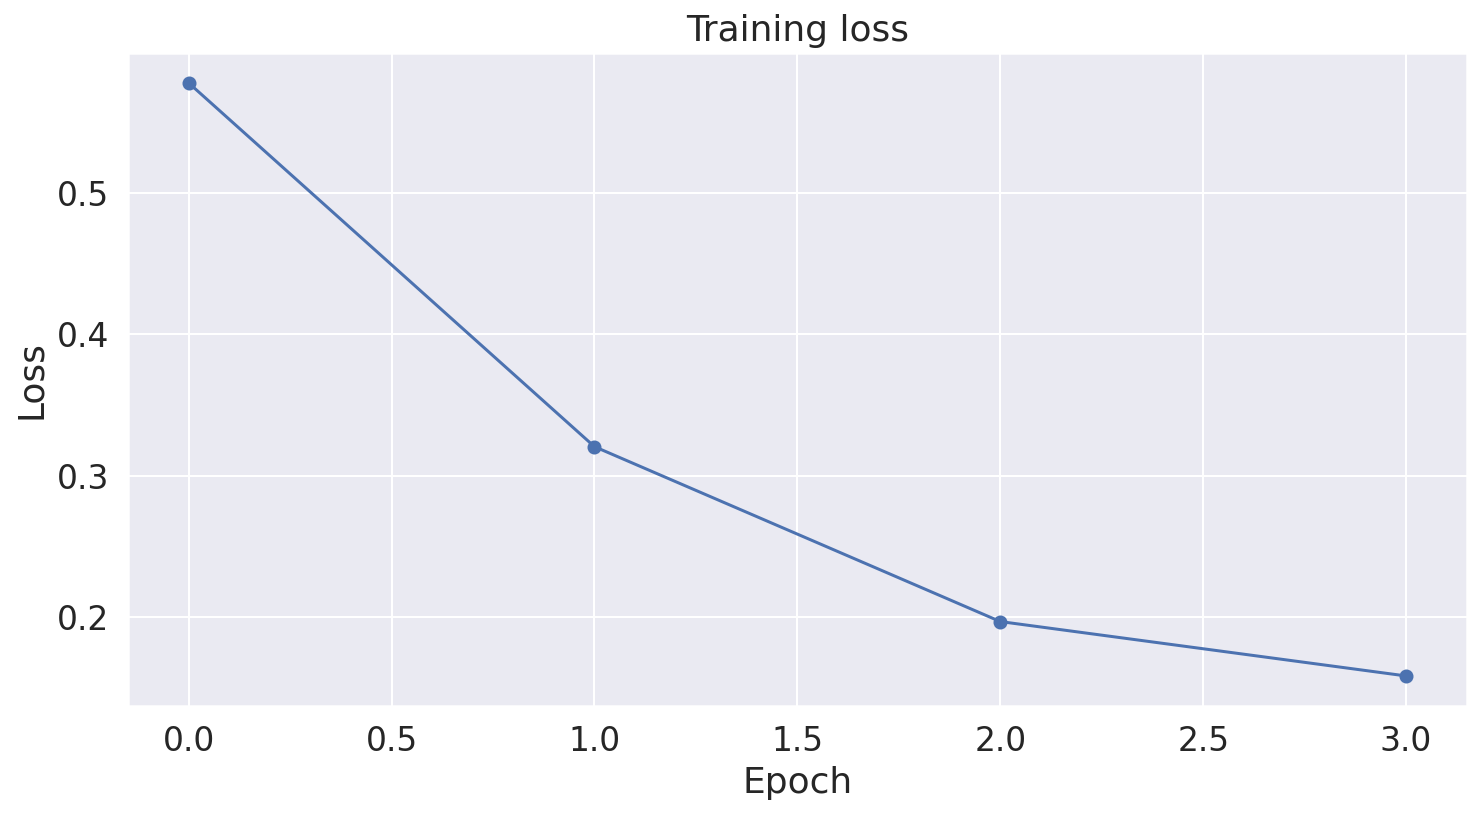

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#### Performance on Test dataset

In [ ]:
test_batch = tokenizer(
    test_data['sent0'].tolist(), 
    test_data['sent1'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

prediction_inputs = test_batch.input_ids
prediction_masks = test_batch.attention_mask
prediction_labels = torch.tensor(test_label[1])

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('Evaluation DONE.')

Predicting labels for 1,000 test sentences...
Evaluation DONE.


In [ ]:
print('Sentence 1 not making common sense: %d of %d (%.2f%%)' % (test_label[1].sum(), len(test_label[1]), (test_label[1].sum() / len(test_label[1]) * 100.0)))
print('Sentence 0 not making common sense: %d of %d (%.2f%%)' % ((test_label[1]==0).sum(), len(test_label[1]), ((test_label[1]==0).sum() / len(test_label[1]) * 100.0)))

Sentence 1 not making common sense: 492 of 1000 (49.20%)
Sentence 0 not making common sense: 508 of 1000 (50.80%)


Because classes are balanced, we use the simple accuracy.

In [ ]:
pred_labels = []
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.array(flat_true_labels)

In [ ]:
flat_predictions.shape == flat_true_labels.shape

True

In [ ]:
def test_flat_accuracy(preds, labels):
  return np.sum(preds == labels) / len(labels)
bert_subA_accuracy = test_flat_accuracy(flat_predictions, flat_true_labels)

print("The BERT baseline achieved an accuracy rate of {}".format(bert_subA_accuracy))

The BERT baseline achieved an accuracy rate of 0.823


### Train the DeBERTa model

#### Tokenize

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaModel.from_pretrained('microsoft/deberta-base')

In [ ]:
token_lens = []
for txt in train_data['sent1']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


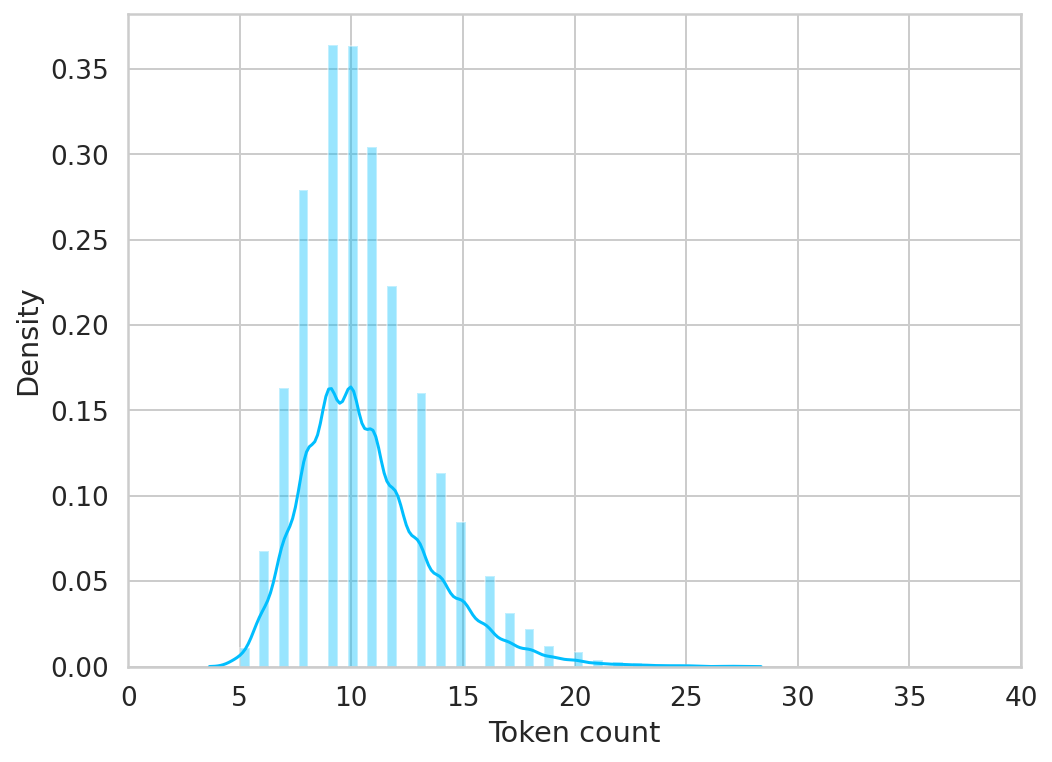

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 40]);
plt.xlabel('Token count');

In [ ]:
print("Max sentence length:", max(token_lens))

Max sentence length: 27


In [ ]:
train_token_pair = tokenizer(train_data['sent0'].tolist(), train_data['sent1'].tolist())

In [ ]:
train_token_pair

{'input_ids': [[1, 894, 13414, 8978, 10580, 15, 39, 25629, 4, 2, 894, 13414, 5803, 15, 39, 25629, 4, 2], [1, 894, 6696, 15162, 4, 2, 894, 6696, 5803, 4, 2], [1, 19663, 2075, 10, 7245, 452, 2, 19663, 2075, 727, 6, 151, 1788, 452, 2], [1, 250, 22443, 1690, 1033, 162, 2, 100, 19049, 10, 22443, 2], [1, 250, 21348, 16, 10, 621, 4, 2, 250, 25650, 17459, 16, 10, 621, 4, 2], [1, 250, 1656, 12, 179, 16198, 16, 2514, 87, 10, 2340, 16198, 4, 2, 250, 2340, 16198, 16, 2514, 87, 10, 1656, 12, 179, 16198, 4, 2], [1, 100, 101, 7, 3068, 127, 7548, 2, 100, 101, 7, 3068, 127, 4806, 2], [1, 250, 272, 5216, 574, 305, 2191, 1941, 248, 15949, 17345, 29892, 40911, 9309, 2, 250, 272, 5216, 574, 305, 2191, 1941, 248, 15949, 17345, 37394, 3388, 2], [1, 700, 342, 18274, 88, 5, 26144, 2, 700, 9650, 514, 11, 7, 5, 26144, 2], [1, 250, 1816, 1974, 14545, 2, 250, 2335, 1974, 14545, 2], [1, 717, 6149, 29, 3529, 449, 354, 15, 9274, 4, 2, 32180, 465, 7689, 15, 9274, 4, 2], [1, 10006, 24313, 10, 27276, 4, 2, 10006, 24313,

In [ ]:
max_seq_len = 27
tokens_train = tokenizer.batch_encode_plus(
    train_token_pair,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# check the pairs
for ids in train_token_pair["input_ids"][:5]:
  print(tokenizer.decode(ids))

He poured orange juice on his cereal.He poured milk on his cereal.
He drinks apple.He drinks milk.
Jeff ran a mile todayJeff ran 100,000 miles today
A mosquito stings meI sting a mosquito
A niece is a person.A giraffe is a person.


In [ ]:
# sending sentence pairs as a list to the tokenizer
train_batch = tokenizer(
    train_data['sent0'].tolist(), 
    train_data['sent1'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

dev_batch = tokenizer(
    dev_data['sent0'].tolist(), 
    dev_data['sent1'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_batch.input_ids

tensor([[    1,   894, 13414,  ...,     0,     0,     0],
        [    1,   894,  6696,  ...,     0,     0,     0],
        [    1, 19663,  2075,  ...,     0,     0,     0],
        ...,
        [    1, 29345,   439,  ..., 11121, 21298,     2],
        [    1, 16626,    16,  ...,     0,     0,     0],
        [    1,   100,    33,  ...,     0,     0,     0]])

In [ ]:
train_batch.attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
# for train set
train_inputs = train_batch.input_ids
train_labels = torch.tensor(train_label[1])
train_masks = train_batch.attention_mask

# for dev set
dev_inputs = dev_batch.input_ids
dev_labels = torch.tensor(dev_label[1])
dev_masks = dev_batch.attention_mask

#### DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_tensor_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_tensor_data)
train_dataloader = DataLoader(train_tensor_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_tensor_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
validation_sampler = SequentialSampler(validation_tensor_data)
validation_dataloader = DataLoader(validation_tensor_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import DebertaForSequenceClassification, AdamW, DebertaConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = DebertaForSequenceClassification.from_pretrained(
    "microsoft/deberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The DeBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:3]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[3:19]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# for p in params[:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The DeBERTa model has 200 different named parameters.

==== Embedding Layer ====

deberta.embeddings.word_embeddings.weight               (50265, 768)
deberta.embeddings.LayerNorm.weight                           (768,)
deberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

deberta.encoder.layer.0.attention.self.q_bias                 (768,)
deberta.encoder.layer.0.attention.self.v_bias                 (768,)
deberta.encoder.layer.0.attention.self.in_proj.weight    (2304, 768)
deberta.encoder.layer.0.attention.self.pos_proj.weight    (768, 768)
deberta.encoder.layer.0.attention.self.pos_q_proj.weight   (768, 768)
deberta.encoder.layer.0.attention.self.pos_q_proj.bias        (768,)
deberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
deberta.encoder.layer.0.attention.output.dense.bias           (768,)
deberta.encoder.layer.0.attention.output.LayerNorm.weight       (768,)
deberta.encoder.layer.0.attention.output.LayerNorm.bias  

#### Optimizer & Learning Rate Scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# number of epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

#### Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Helper function for formatting elapsed times.
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Kick off the training

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 266

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:06.
  Batch    80  of    313.    Elapsed: 0:00:12.
  Batch   120  of    313.    Elapsed: 0:00:18.
  Batch   160  of    313.    Elapsed: 0:00:24.
  Batch   200  of    313.    Elapsed: 0:00:30.
  Batch   240  of    313.    Elapsed: 0:00:36.
  Batch   280  of    313.    Elapsed: 0:00:42.

  Average training loss: 0.66
  Training epcoh took: 0:00:47

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:06.
  Batch    80  of    313.    Elapsed: 0:00:12.
  Batch   120  of    313.    Elapsed: 0:00:18.
  Batch   160  of    313.    Elapsed: 0:00:24.
  Batch   200  of    313.    Elapsed: 0:00:30.
  Batch   240  of    313.    Elapsed: 0:00:36.
  Batch   280  of    313.    Elapsed: 0:00:42.

  Average training loss: 0.34
  Training epcoh took: 0:00:47

Running Validation...
  Accuracy: 0.89
  Validation took: 0:00:0

Take a look at training loss over all batches

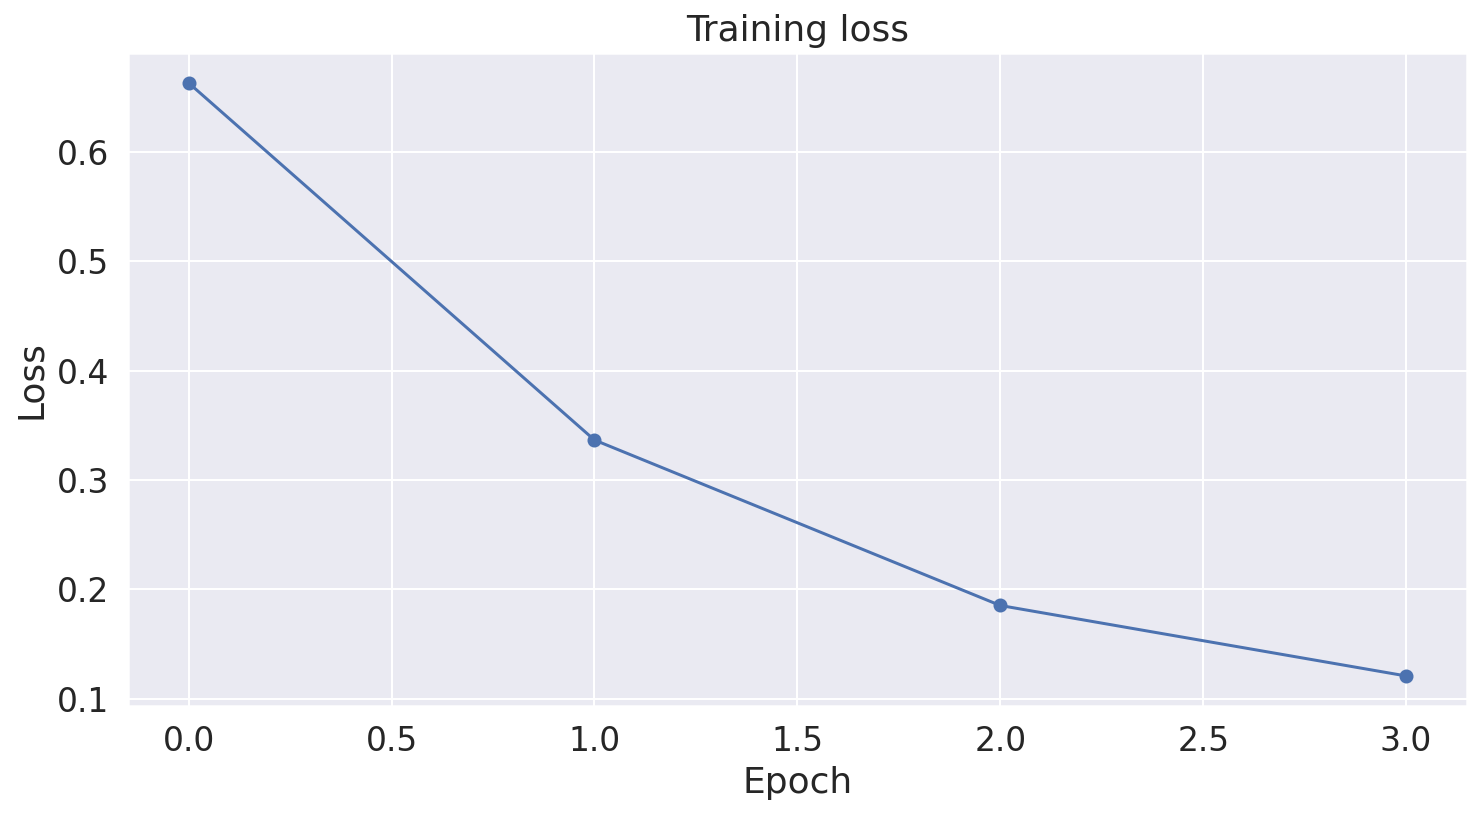

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#### Performance on Test dataset

In [ ]:
test_batch = tokenizer(
    test_data['sent0'].tolist(), 
    test_data['sent1'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

prediction_inputs = test_batch.input_ids
prediction_masks = test_batch.attention_mask
prediction_labels = torch.tensor(test_label[1])

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('Evaluation DONE.')

Predicting labels for 1,000 test sentences...
Evaluation DONE.


In [ ]:
print('Sentence 1 not making common sense: %d of %d (%.2f%%)' % (test_label[1].sum(), len(test_label[1]), (test_label[1].sum() / len(test_label[1]) * 100.0)))
print('Sentence 0 not making common sense: %d of %d (%.2f%%)' % ((test_label[1]==0).sum(), len(test_label[1]), ((test_label[1]==0).sum() / len(test_label[1]) * 100.0)))

Sentence 1 not making common sense: 492 of 1000 (49.20%)
Sentence 0 not making common sense: 508 of 1000 (50.80%)


Because classes are balanced, we use the simple accuracy.

In [ ]:
pred_labels = []
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.array(flat_true_labels)

In [ ]:
flat_predictions.shape == flat_true_labels.shape

True

In [ ]:
def test_flat_accuracy(preds, labels):
  return np.sum(preds == labels) / len(labels)
bert_subA_accuracy = test_flat_accuracy(flat_predictions, flat_true_labels)

print("The DeBerta achieved an accuracy rate of {}".format(bert_subA_accuracy))

The DeBerta achieved an accuracy rate of 0.878


## Subtask A - Single Sentence Model

In [ ]:
# sample data
text = ["this is a bert model baseline", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

print(sent_id)

{'input_ids': [[1, 9226, 16, 10, 741, 2399, 1421, 18043, 2, 0, 0, 0], [1, 1694, 40, 2051, 12, 90, 4438, 10, 741, 2399, 1421, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


### Tokenization

In [ ]:
# train (label = 1 if against common sense)
train_text0 = train_data['sent0']
train_text1 = train_data['sent1']

train_label0 = train_label[1] == 0
train_label1 = train_label[1] == 1

# dev
dev_text0 = dev_data['sent0']
dev_text1 = dev_data['sent1']
dev_label0 = dev_label[1] == 0
dev_label1 = dev_label[1] == 1

# test
test_text0 = test_data['sent0']
test_text1 = test_data['sent1']
test_label0 = test_label[1] == 0
test_label1 = test_label[1] == 1


In [ ]:
# tokenize and encode sequences in the training set
max_seq_len = 25
tokens_train = tokenizer.batch_encode_plus(
    train_text0.tolist(),
    # train_text1.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_dev = tokenizer.batch_encode_plus(
    dev_text0.tolist(),
    # dev_text1.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    test_text0.tolist(),
    # test_text1.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


In [ ]:
len(tokens_train['input_ids'])


In [ ]:
tokens_train['input_ids'][1]

In [ ]:
len(tokens_train['attention_mask'])

### Convert integer seq to tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_label0.tolist())

# for dev set
dev_seq = torch.tensor(tokens_dev['input_ids'])
dev_mask = torch.tensor(tokens_dev['attention_mask'])
dev_y = torch.tensor(dev_label0.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_label0.tolist())

### Create Data Loaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_tensordata = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_tensordata)

# dataLoader for train set
train_dataloader = DataLoader(train_tensordata, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
dev_tensordata = TensorDataset(dev_seq, dev_mask, dev_y)

# sampler for sampling the data during training
dev_sampler = SequentialSampler(dev_tensordata)

# dataLoader for dev set
dev_dataloader = DataLoader(dev_tensordata, sampler = dev_sampler, batch_size=batch_size)

In [ ]:
train_seq.shape

In [ ]:
train_seq.type

In [ ]:
train_mask.shape

In [ ]:
train_y.shape

### Freeze BERT parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

### Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_label0), train_label0)

print(class_wts)

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
#weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 



In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(dev_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dev_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the dev loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the dev loss of the epoch
  avg_loss = total_loss / len(dev_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Start Model Training

In [ ]:
# number of training epochs
epochs = 10

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


TypeError: ignored

In [ ]:
batch

{'input_ids': tensor([[  101,  2002,  8542,  ...,     0,     0,     0],
        [  101,  2002,  8974,  ...,     0,     0,     0],
        [  101,  5076,  2743,  ...,     0,     0,     0],
        ...,
        [  101,  4302,  2253,  ...,  2010,  7877,   102],
        [  101, 13875,  2003,  ...,     0,     0,     0],
        [  101,  1045,  2031,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
# Convert data into pair of sequences: [CLS] sent0 [SEP] sent1 [SEP]
sent0_tokens = list()
sent0_token_ids = list()
sent1_tokens = list()
sent1_token_ids = list()
train_token_pair = list()

for i in range(5):
  # token ids for sent0
  token0 = tokenizer.tokenize(train_data['sent0'][i])
  sent0_tokens.append(token0)
  token0_id = tokenizer.convert_tokens_to_ids(token0)
  sent0_token_ids.append(token0_id)

  # token ids for sent1
  token1 = tokenizer.tokenize(train_data['sent1'][i])
  sent1_tokens.append(token1)
  token1_id = tokenizer.convert_tokens_to_ids(token1)
  sent1_token_ids.append(token1_id)

  # concat sent0 and sent1 token ids as pairs
  token_pair = tokenizer.build_inputs_with_special_tokens(token0_id, token1_id)
  train_token_pair.append(token_pair)


# print(sent0_tokens)
# print(sent0_token_ids)

# print(sent1_tokens)
# print(sent1_token_ids)

print(train_token_pair)

## Subtask B - Single Sentence Classification Model

### Load datasets for subtask B

There are three missing values in Option C in training data. Given the data size is large. We ignore this.

In [ ]:
train_b_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Training%20%20Data/subtaskB_data_all.csv",keep_default_na=False)
train_b_data.shape

(10000, 5)

In [ ]:
train_b_data.head()

id  ...                                            OptionC
0   0  ...  Orange juice is sticky if you spill it on the ...
1   1  ...                           Apple cannot eat a human
2   2  ...           100,000 miles is longer than 100,000 km.
3   3  ...                             A human has not stings
4   4  ...                      .Giraffes usually eat leaves.

[5 rows x 5 columns]

In [ ]:
train_b_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         10000 non-null  int64 
 1   FalseSent  10000 non-null  object
 2   OptionA    10000 non-null  object
 3   OptionB    10000 non-null  object
 4   OptionC    10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


There are 3 questions only have two choices (i.e. without option C).

In [ ]:
train_b_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Training%20%20Data/subtaskB_answers_all.csv",header=None)
train_b_label.shape

(10000, 2)

In [ ]:
train_b_label.head()

0  1
0  0  B
1  1  B
2  2  A
3  3  C
4  4  B

In [ ]:
# check label distribution --> balanced
print(train_b_label[1].value_counts())
print(train_b_label[1].value_counts(normalize = True))

C    3443
B    3362
A    3195
Name: 1, dtype: int64
C    0.3443
B    0.3362
A    0.3195
Name: 1, dtype: float64


In [ ]:
dev_b_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Dev%20Data/subtaskB_dev_data.csv")
print(dev_b_data.shape)
dev_b_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Dev%20Data/subtaskB_gold_answers.csv",header=None)
print(dev_b_label.shape)
test_b_data = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Test%20Data/subtaskB_test_data.csv")
print(test_b_data.shape)
test_b_label = pd.read_csv("https://github.com/chenxicclu/SemEval2020-Task4-Commonsense-Validation-and-Explanation/raw/master/ALL%20data/Test%20Data/subtaskB_gold_answers.csv",header=None)
test_b_label.shape

(997, 5)
(997, 2)
(1000, 5)


(1000, 2)

In [ ]:
test_b_data

id  ...                                            OptionC
0    1175  ...           Some beds are big while some are smaller
1     452  ...                       An inverter is rechargeable.
2     275  ...                    Lemons are not a pizza topping.
3     869  ...               sugar usually is used as a sweetener
4      50  ...                A plane can never be seen in garden
..    ...  ...                                                ...
995  1114  ...                  People feel mess if they are wet.
996     8  ...  There are no relationships between ice hockey ...
997  1945  ...  Water more deep in a container cannot always b...
998  1053  ...                       The desert has lots of sand.
999  1123  ...        2 inches is too short a distance to be ran.

[1000 rows x 5 columns]

In [ ]:
test_b_label

0  1
0    1175  A
1     452  B
2     275  C
3     869  C
4      50  C
..    ... ..
995  1114  A
996     8  C
997  1945  B
998  1053  B
999  1123  C

[1000 rows x 2 columns]

### BERT

#### tokenize

In [ ]:
# Load the BERT tokenizer and BERT for multiple choice
from transformers import BertTokenizer, BertForMultipleChoice, BertForPreTraining
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForMultipleChoice.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased')

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Reshape Training Data and Labels

In [ ]:
# data
df_a = train_b_data[['id','FalseSent','OptionA']]
df_b = train_b_data[['id','FalseSent','OptionB']]
df_c = train_b_data[['id','FalseSent','OptionC']]


for df in df_a,df_b,df_c:
  df.columns = ['id','FalseSent','Option']

train_b_data_concat = pd.concat([df_a, df_b, df_c])

# labels
df_a_label = (train_b_label[1] == "A")
df_b_label = (train_b_label[1] == "B")
df_c_label = (train_b_label[1] == "C")
train_b_label_concat = pd.concat([df_a_label, df_b_label, df_c_label])

train_b_data_concat['Label'] =  train_b_label_concat
train_b_data_concat['Label'] =  train_b_data_concat['Label'].astype(int)

# sort by id (put the same sentences together, 3 as a group)
train_b_data_concat.sort_values(by = 'id', ignore_index= True, inplace=True)

# restructured dataframe
train_b_data_concat

id  ... Label
0         0  ...     0
1         0  ...     0
2         0  ...     1
3         1  ...     0
4         1  ...     0
...     ...  ...   ...
29995  9998  ...     0
29996  9998  ...     0
29997  9999  ...     0
29998  9999  ...     0
29999  9999  ...     1

[30000 rows x 4 columns]

Reshape Dev Data and Labels

In [ ]:
dev_a = dev_b_data[['id','FalseSent','OptionA']]
dev_b = dev_b_data[['id','FalseSent','OptionB']]
dev_c = dev_b_data[['id','FalseSent','OptionC']]


for df in dev_a,dev_b,dev_c:
  df.columns = ['id','FalseSent','Option']

dev_b_data_concat = pd.concat([dev_a, dev_b, dev_c])

# labels
dev_label_a = (dev_b_label[1] == "A")
dev_label_b  = (dev_b_label[1] == "B")
dev_label_c  = (dev_b_label[1] == "C")
dev_b_label_concat = pd.concat([dev_label_a, dev_label_b, dev_label_c])

dev_b_data_concat['Label'] =  dev_b_label_concat
dev_b_data_concat['Label'] =  dev_b_data_concat['Label'].astype(int)

# sort by id (put the same sentences together, 3 as a group)
dev_b_data_concat.sort_values(by = 'id', ignore_index= True, inplace=True)

# restructured dataframe
dev_b_data_concat

id  ... Label
0        1  ...     0
1        1  ...     1
2        1  ...     0
3        3  ...     0
4        3  ...     1
...    ...  ...   ...
2986  1994  ...     0
2987  1994  ...     1
2988  1995  ...     0
2989  1995  ...     1
2990  1995  ...     0

[2991 rows x 4 columns]

In [ ]:
max_seq_len_b = 36
train_b_token = bert_tokenizer(
    train_b_data_concat['FalseSent'].tolist(),
    train_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

dev_b_token = bert_tokenizer(
    dev_b_data_concat['FalseSent'].tolist(),
    dev_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for train set
train_b_inputs = train_b_token.input_ids
train_b_labels = torch.tensor(train_b_data_concat['Label'])
train_b_masks = train_b_token.attention_mask

# for dev set
dev_b_inputs = dev_b_token.input_ids
dev_b_labels = torch.tensor(dev_b_data_concat['Label'])
dev_b_masks = dev_b_token.attention_mask


#### DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_tensor_data = TensorDataset(train_b_inputs, train_b_masks, train_b_labels)
train_sampler = RandomSampler(train_tensor_data)
train_dataloader = DataLoader(train_tensor_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_tensor_data = TensorDataset(dev_b_inputs, dev_b_masks, dev_b_labels)
validation_sampler = SequentialSampler(validation_tensor_data)
validation_dataloader = DataLoader(validation_tensor_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 206 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

#### Optimizer & Learning Rate Scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# number of epochs
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

#### Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Helper function for formatting elapsed times.
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Kick off the training

In [ ]:
inputs = bert_tokenizer("He poured orange juice on his cereal.", "Orange juice doesn't taste good on cereal", return_tensors="pt")
inputs = inputs.to(device)
outputs = model(**inputs)
prediction_logits = outputs.prediction_logits
seq_relationship_logits = outputs.seq_relationship_logits

In [ ]:
cls = prediction_logits[:,0,:]

In [ ]:
inputs

{'input_ids': tensor([[  101,  2002,  8542,  4589, 10869,  2006,  2010, 20943,  1012,   102,
          4589, 10869,  2987,  1005,  1056,  5510,  2204,  2006, 20943,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [ ]:
cls.shape

torch.Size([1, 30522])

In [ ]:
model.hidden = 

tensor([[ 6.2245, -6.0039]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
prediction_logits[0][7]

tensor([-10.7487, -10.7045, -10.4612,  ...,  -7.5649,  -8.4976,  -9.1996],
       device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
train_dataloader

TypeError: ignored

In [ ]:
outputs = model(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)

# The call to `model` always returns a tuple, so we need to pull the 
# loss value out of the tuple.
loss = outputs[0]

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 266

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...


ValueError: ignored

Take a look at training loss over all batches

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

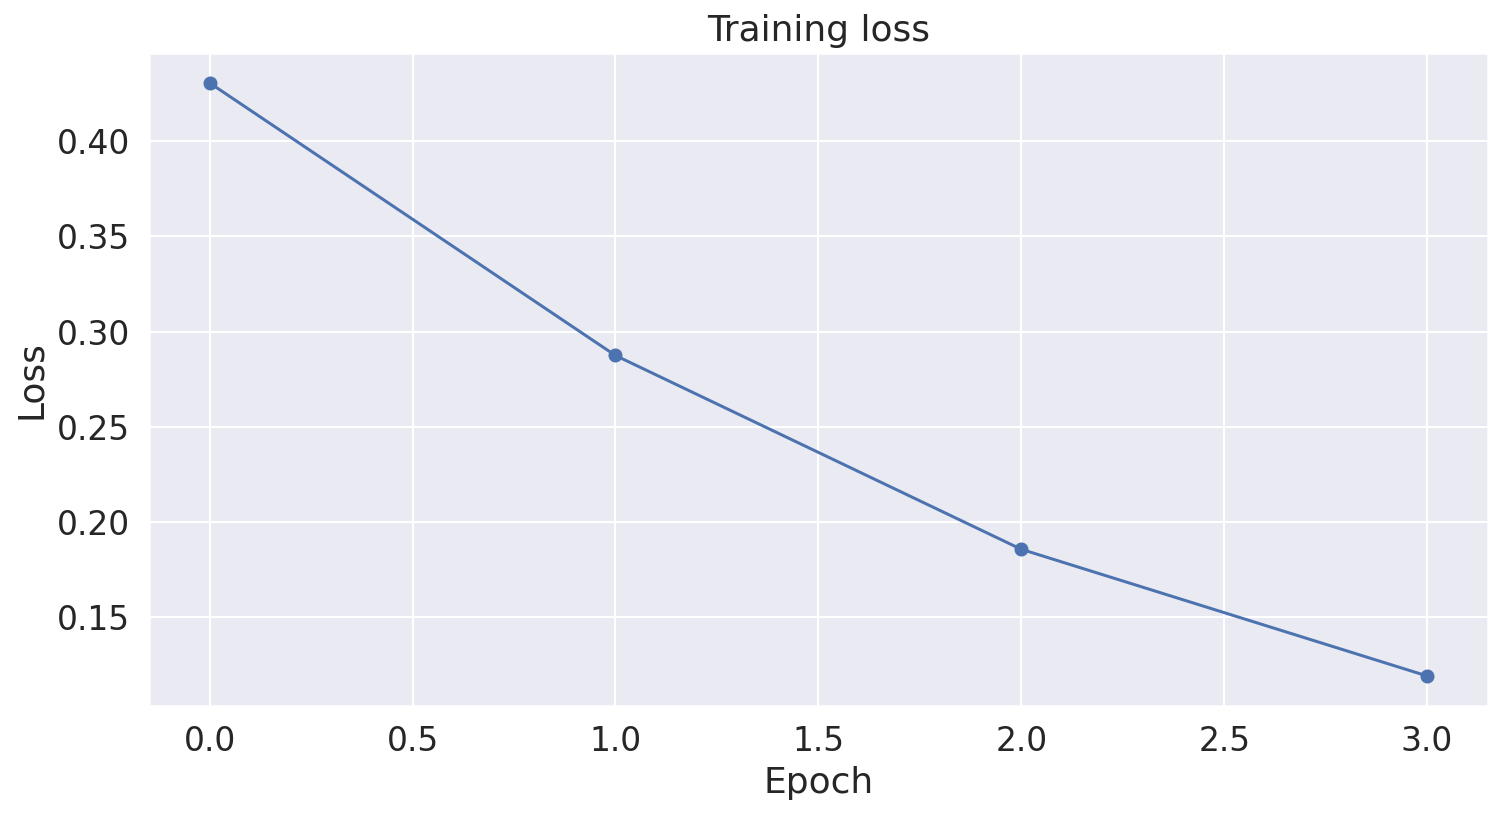

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#### Performance on Test dataset

Reshape the Test Dataset

In [ ]:
test_a = test_b_data[['id','FalseSent','OptionA']]
test_b = test_b_data[['id','FalseSent','OptionB']]
test_c = test_b_data[['id','FalseSent','OptionC']]


for df in test_a,test_b,test_c:
  df.columns = ['id','FalseSent','Option']

test_b_data_concat = pd.concat([test_a, test_b, test_c])

# labels
test_label_a = (test_b_label[1] == "A")
test_label_b  = (test_b_label[1] == "B")
test_label_c  = (test_b_label[1] == "C")
test_b_label_concat = pd.concat([test_label_a, test_label_b, test_label_c])

test_b_data_concat['Label'] =  test_b_label_concat
test_b_data_concat['Label'] =  test_b_data_concat['Label'].astype(int)

# sort by id (put the same sentences together, 3 as a group)
test_b_data_concat.sort_values(by = 'id', ignore_index= True, inplace=True)

# restructured dataframe
test_b_data_concat.head(20)

id  ... Label
0        2  ...     0
1        2  ...     1
2        2  ...     0
3        6  ...     0
4        6  ...     0
...    ...  ...   ...
2995  1996  ...     0
2996  1996  ...     0
2997  1997  ...     0
2998  1997  ...     1
2999  1997  ...     0

[3000 rows x 4 columns]

In [ ]:
test_b_data_concat.head(20)

NameError: ignored

In [ ]:
test_batch = bert_tokenizer(
    test_b_data_concat['FalseSent'].tolist(),
    test_b_data_concat['Option'].tolist(),
    max_length = max_seq_len_b,
    pad_to_max_length=True,
    truncation=True, 
    return_tensors="pt"
    )

prediction_inputs = test_batch.input_ids
prediction_masks = test_batch.attention_mask
prediction_labels = torch.tensor(test_b_data_concat['Label'])

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('Evaluation DONE.')

Predicting labels for 3,000 test sentences...
Evaluation DONE.


Use the simple accuracy.

In [ ]:
pred_labels = []
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.array(flat_true_labels)

In [ ]:
flat_predictions.shape == flat_true_labels.shape

True

In [ ]:
def test_flat_accuracy(preds, labels):
  return np.sum(preds == labels) / len(labels)
bert_subA_accuracy = test_flat_accuracy(flat_predictions, flat_true_labels)

print("The BERT baseline achieved an accuracy rate of {}".format(bert_subA_accuracy))

The BERT baseline achieved an accuracy rate of 0.6453333333333333


In [ ]:
from transformers import BertTokenizer, BertForMultipleChoice, BertForPreTraining
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased')

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
prompt = ["He poured orange juice on his cereal. This does not make sense because Orange juice is usually bright orange.",
          "He poured orange juice on his cereal. This does not make sense because Orange juice doesn't taste good on cereal.",
          "He poured orange juice on his cereal. This does not make sense because Orange juice is sticky if you spill it on the table."]

encoding = bert_tokenizer(prompt, return_tensors='pt', padding=True)
outputs = model(**encoding)  # batch size is 1
# the linear classifier still needs to be trained
loss = outputs.loss

In [ ]:
cls = outputs[0][:,0,:]


In [ ]:
cls

tensor([[-8.3286, -8.3708, -8.2495,  ..., -7.5959, -7.8373, -4.8292],
        [-8.4198, -8.4592, -8.3313,  ..., -7.5787, -7.8167, -4.9894],
        [-8.0125, -8.0230, -7.9086,  ..., -7.2572, -7.2605, -4.7176]],
       grad_fn=<SliceBackward>)

In [ ]:
outputs[0].shape

torch.Size([3, 28, 30522])

In [ ]:
bert_tokenizer.encode(prompt[2])

[101,
 2002,
 8542,
 4589,
 10869,
 2006,
 2010,
 20943,
 1012,
 2023,
 2515,
 2025,
 2191,
 3168,
 2138,
 4589,
 10869,
 2003,
 15875,
 2065,
 2017,
 14437,
 2009,
 2006,
 1996,
 2795,
 1012,
 102]

In [ ]:

prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
choice0 = "It is eaten with a fork and a knife."
choice1 = "It is eaten while held in the hand."
labels = torch.tensor(0).unsqueeze(0)  # choice0 is correct (according to Wikipedia ;)), batch size 1
encoding = bert_tokenizer([[prompt, prompt], [choice0, choice1]], return_tensors='pt', padding=True)
outputs = model(**{k: v.unsqueeze(0) for k,v in encoding.items()}, labels=labels)  # batch size is 1
# the linear classifier still needs to be trained
loss = outputs.loss
logits = outputs.logits

In [ ]:
encoding

{'input_ids': tensor([[  101,  1999,  3304,  1010, 10733,  2366,  1999,  5337, 10906,  1010,
          2107,  2004,  2012,  1037,  4825,  1010,  2003,  3591,  4895, 14540,
          6610,  2094,  1012,   102,  1999,  3304,  1010, 10733,  2366,  1999,
          5337, 10906,  1010,  2107,  2004,  2012,  1037,  4825,  1010,  2003,
          3591,  4895, 14540,  6610,  2094,  1012,   102],
        [  101,  2009,  2003,  8828,  2007,  1037,  9292,  1998,  1037,  5442,
          1012,   102,  2009,  2003,  8828,  2096,  2218,  1999,  1996,  2192,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [ ]:
loss

tensor(0.6287, grad_fn=<NllLossBackward>)

In [ ]:
logits

tensor([[0.3385, 0.2052]], grad_fn=<ViewBackward>)

In [ ]:
len(outputs)
outputs[0]
outputs[1]

tensor([[0.3385, 0.2052]], grad_fn=<ViewBackward>)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Max sentence length: 36


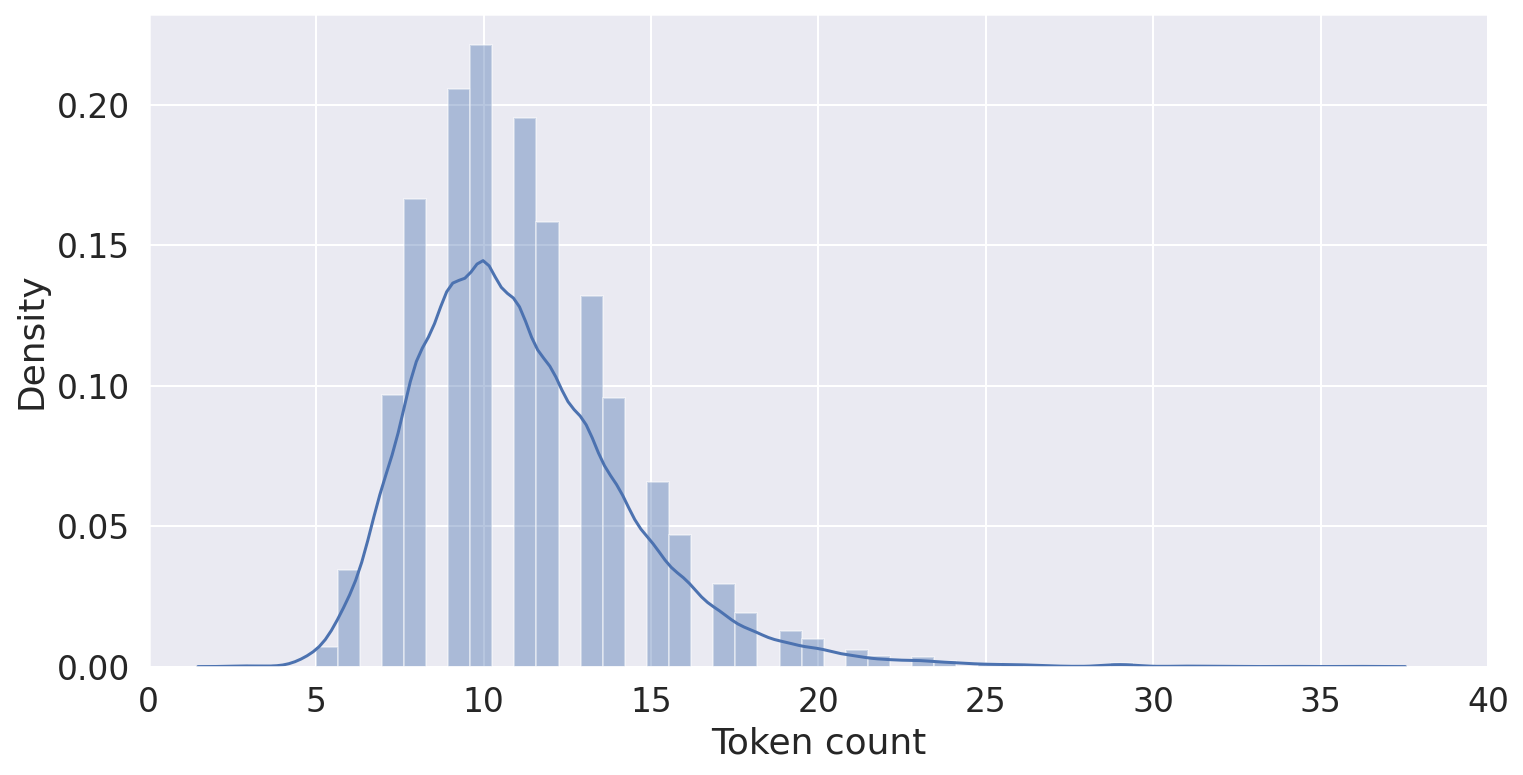

In [ ]:
token_b_lens = []
for txt in train_b_data['OptionC']:
  tokens_b = tokenizer.encode(str(txt), max_length=512)
  token_b_lens.append(len(tokens_b))

sns.distplot(token_b_lens)
plt.xlim([0, 40])
plt.xlabel('Token count')

print("Max sentence length:", max(token_b_lens))

In [ ]:
max_seq_len = 32
tokens_train = tokenizer.batch_encode_plus(
    train_b_token,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
train_b_token

{'input_ids': [[101, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

DeBERTa

## Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)

# sampler for sampling the data during training
dev_sampler = SequentialSampler(dev_data)

# dataLoader for development set
dev_dataloader = DataLoader(dev_data, sampler = dev_sampler, batch_size=batch_size)

In [ ]:
len(example1)==len(example2)

In [ ]:
len(example1)

In [ ]:
len(example2)

In [ ]:
tokenizer.sep_token

In [ ]:
tokenizer.cls_token

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [ ]:
last_hidden_states.shape

In [ ]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

In [ ]:
tokenizer.tokenize('This sentence is simple and uses a nice dataset')

In [ ]:
sample_txt = "This sentence is simple and uses a nice dataset"
tokens = tokenizer.tokenize(sample_txt)
print(tokens)

In [ ]:
tokenizer.convert_ids_to_tokens([290])

In [ ]:
input_ids = np.array([tokenizer.encode('I am very happy today. [PAD] [PAD] [PAD]')])
input_ids

In [ ]:
tokenizer.convert_ids_to_tokens([182])

In [ ]:
tokenizer.convert_tokens_to_ids([4])

In [ ]:
# for layer in range(11):
#     print(layer)
#     print('Layer name: \t', model.layers[0].weights[layer].name)
#     print('Layer shape: \t', model.layers[0].weights[layer].shape)

In [ ]:
from transformers import DebertaTokenizer, DebertaForMaskedLM
import torch
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaForMaskedLM.from_pretrained('microsoft/deberta-base')
inputs = tokenizer("The capital of France is [MASK].", return_tensors="pt")
labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

In [ ]:
outputs

In [ ]:
labels

In [ ]:
loss